In [1]:
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
from math import log
from scipy.sparse import coo_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import mode
from experiment import EarlyStop, train_model
import os
import sys
import pickle
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.multiprocessing as multiprocessing

import utils.Constant as CONSTANT
from dataloader import UIRTDatset
from evaluation import Evaluator

import warnings

warnings.filterwarnings("ignore")

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

In [2]:
gpu = 0
gpu = str(gpu)
os.environ["CUDA_VISIBLE_DEVICES"] = gpu 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = "data/recsys_data"
dataset = "ml-1m"
min_user_per_item = 1
min_item_per_user = 10

# leave-k-out
leave_k = 5
popularity_order = True

dataset = UIRTDatset(data_dir, dataset, min_user_per_item, min_item_per_user, leave_k, popularity_order)

data loaded!


In [3]:
# # model name MultVAE, LOCA_VAE, MOE
# vae_scores = np.load('./data/recsys_data/ml-1m/mainstream_scores/MultVAE_scores/vae_scores.npy', allow_pickle=True)
# vae_ndcg_score = vae_scores.item()['NDCG@20']
# vae_ndcg_score = np.array(vae_ndcg_score)
# print(len(vae_ndcg_score))
# print(dataset.num_users)

In [4]:
ms_similarity = np.load('./data/recsys_data/ml-1m/mainstream_scores/MS_similarity.npy')
# print(max(ms_similarity))
# print(min(ms_similarity))

In [5]:
def distribution_plot(x, y, bins=20):
    x_max = np.max(x)
    x_min = np.min(x)
    step = (x_max - x_min) / bins
    x_array = []
    mean_array = []
    std_array = []
    for i in range(bins):
        start = x_min + step * i
        end = x_min + step * (i + 1)
        x_array.append((start + end) / 2)
        tmp = y[np.where((x >= start) & (x <= end))[0]]
        mean_array.append(np.mean(tmp) if len(tmp) > 0 else 0)
        std_array.append(np.std(tmp) if len(tmp) > 0 else 0)
    print(mean_array)
    plt.rcParams.update({'font.size': 15})
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 3))
    axes.bar(x_array, mean_array, yerr=std_array, align='center', alpha=0.7, ecolor='black', capsize=5, width=step / 2)
    axes.grid(True)
    axes.set_ylim(0., 0.6)
    fig.tight_layout()
    fig.patch.set_facecolor('white')
    plt.show()

In [6]:
user_sort_idx = np.argsort(ms_similarity)
# print(np.append(user_sort_idx[:1000], user_sort_idx[5000:]))
# distribution_plot(np.arange(dataset.num_users), vae_ndcg_score[user_sort_idx], bins=5)

In [7]:
# bagging_avg = np.load('./data/recsys_data/ml-1m/mainstream_scores/20221216-1211_bagging_scores_1/bagging_scores.npy', allow_pickle=True)
# bagging_avg = bagging_avg.item()['NDCG@20']
# bagging_avg = np.array(bagging_avg)
# distribution_plot(np.arange(dataset.num_users), bagging_avg[user_sort_idx], bins=5)

[0.24705369337379982, 0.2785349691267396, 0.2984945993080733, 0.3620181037038579, 0.4542181089011323]


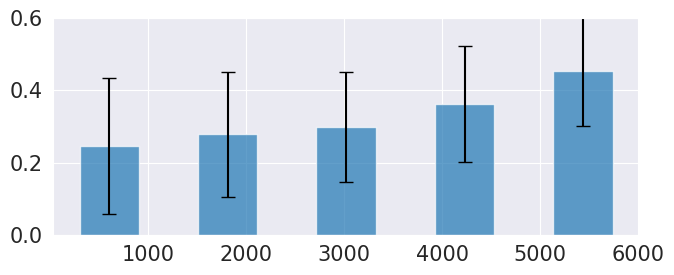

In [8]:
wl = np.load('./data/recsys_data/ml-1m/mainstream_scores/MultVAE_wl_scores/20230128-1636_wl_scores.npy', allow_pickle=True)
wl = wl.item()['NDCG@20']
wl = np.array(wl)
distribution_plot(np.arange(dataset.num_users), wl[user_sort_idx], bins=5)

In [9]:
# entropy normalize
# 30_20221118-1602_moe_test_scores_3m3.npy
# 30_20221120-1906_moe_test_scores_3m3_gate_para_fixed_1layer.npy
# 30_20221120-1922_moe_test_scores_3m3_gate_para_fixed_3layers.npy
# 30_20221120-1947_moe_test_scores_3m3_average_experts.npy
# moe_folder/MOE_scores_20221130-0511/30_moe_test_scores.npy

enlft_scores = np.load('./data/recsys_data/ml-1m/mainstream_scores/EnLFT_scores/20230125-0414_100_EnLFT_scores_new_preprocess.npy', allow_pickle=True)
enlft_scores = enlft_scores.item()['NDCG@20']
enlft_ndcg = np.array(enlft_scores)

[0.25382029043438603, 0.28632472479490195, 0.30317889614076465, 0.36686438057181053, 0.4557855136004127]


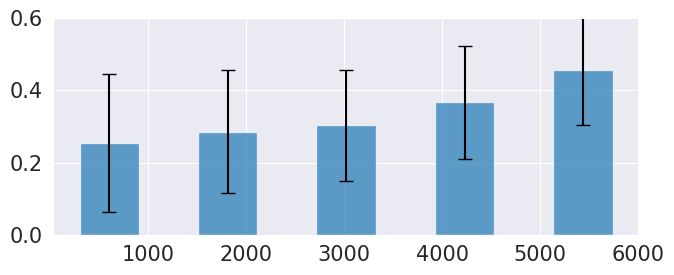

In [10]:
distribution_plot(np.arange(dataset.num_users), enlft_ndcg[user_sort_idx], bins=5)

[0.25854427706483374, 0.28778924724007665, 0.3028248225941657, 0.3663353532586841, 0.4557585714078519]


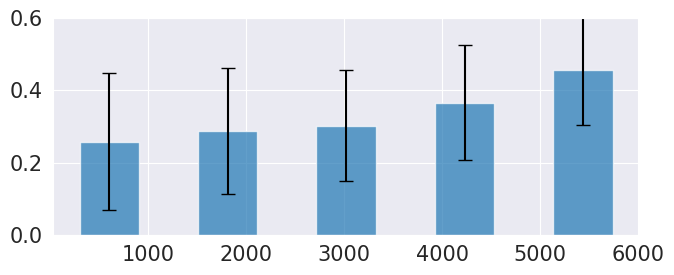

In [11]:
enlft_scores_wl = np.load('./data/recsys_data/ml-1m/mainstream_scores/EnLFT_scores_wl/20230109-0401_100_EnLFT_scores_new_preprocess.npy', allow_pickle=True)
enlft_scores_wl = enlft_scores_wl.item()['NDCG@20']
enlft_scores_wl = np.array(enlft_scores_wl)
distribution_plot(np.arange(dataset.num_users), enlft_scores_wl[user_sort_idx], bins=5)

[0.26747364066462653, 0.2900102181053386, 0.30826490113112964, 0.37091019567850864, 0.4625447691982355]


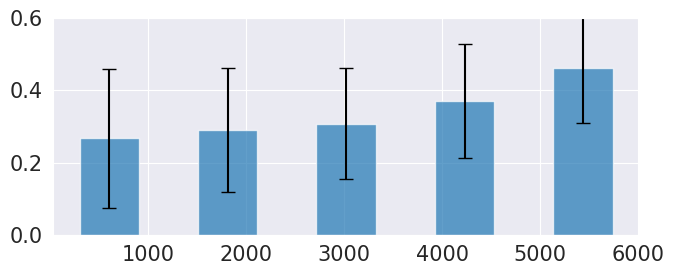

In [12]:
lft_scores = np.load('./data/recsys_data/ml-1m/mainstream_scores/LFT_scores/LFT_scores_new_preprocess.npy', allow_pickle=True)
lft_scores = lft_scores.item()['NDCG@20']
lft_ndcg = np.array(lft_scores)
distribution_plot(np.arange(dataset.num_users), lft_ndcg[user_sort_idx], bins=5)

[0.27128183985834575, 0.29166659016408036, 0.30738634920529323, 0.37324082657377217, 0.4660527459433159]


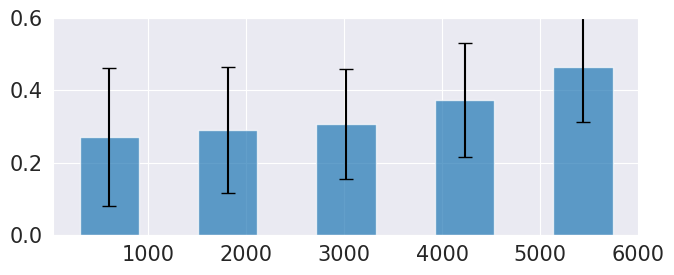

In [13]:
lft_scores_wl = np.load('./data/recsys_data/ml-1m/mainstream_scores/LFT_scores_wl/20230109-0809_LFT_scores_new_preprocess.npy', allow_pickle=True)
lft_scores_wl = lft_scores_wl.item()['NDCG@20']
lft_scores_wl = np.array(lft_scores_wl)
distribution_plot(np.arange(dataset.num_users), lft_scores_wl[user_sort_idx], bins=5)

[0.2573540750751807, 0.279898336718691, 0.29960482502656693, 0.364877541462082, 0.4602522726472251]


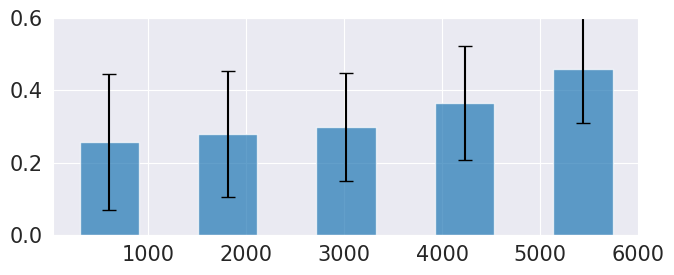

In [14]:
loca_scores = np.load('./data/recsys_data/ml-1m/mainstream_scores/loca_vae_folder/loca_vae_scores_20221208-2309/100_loca_vae_test_scores.npy', allow_pickle=True)
loca_scores = loca_scores.item()['NDCG@20']
loca_ndcg = np.array(loca_scores)
distribution_plot(np.arange(dataset.num_users), loca_ndcg[user_sort_idx], bins=5)

[0.23893958309372107, 0.27646910140609493, 0.2959368089473002, 0.3626083872034584, 0.45303714902684417]


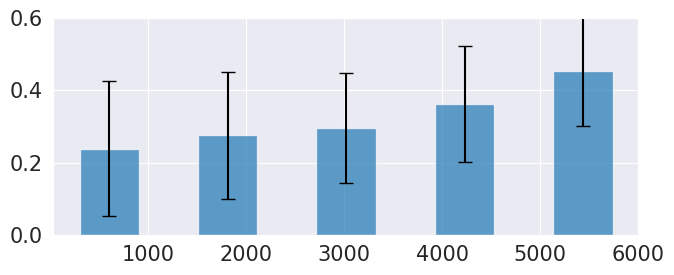

In [15]:
wl_avg = np.load('./data/recsys_data/ml-1m/mainstream_scores/MultVAE_wl_scores/ml_scores.npy', allow_pickle=True)
wl_avg = wl_avg.item()['NDCG@20']
wl_avg = np.array(wl_avg)
distribution_plot(np.arange(dataset.num_users), wl_avg[user_sort_idx], bins=5)

[0.25906903055141906, 0.2777853680003892, 0.30032021586095375, 0.3617347989832237, 0.44967054628200537]


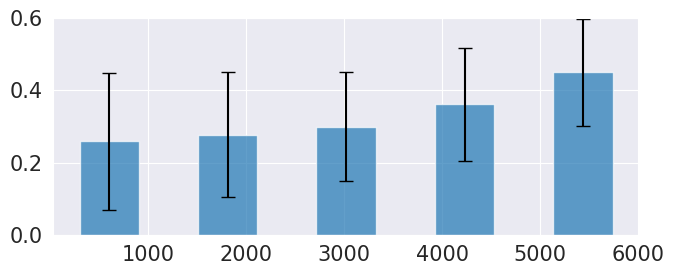

In [16]:
moe_avg = np.load('./data/recsys_data/ml-1m/mainstream_scores/moe_folder/MOE_scores_20230109-0331/100_moe_test_scores.npy', allow_pickle=True)
moe_avg = moe_avg.item()['NDCG@20']
moe_avg = np.array(moe_avg)
distribution_plot(np.arange(dataset.num_users), moe_avg[user_sort_idx], bins=5)

[0.25772369503419823, 0.2756006530442122, 0.2948166942244818, 0.35613835201825356, 0.4481605844035625]


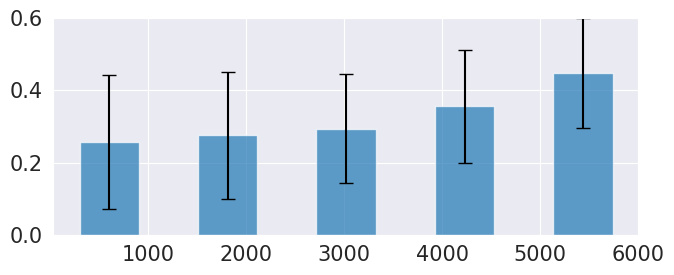

In [17]:
# 20230120-1807
moe_wl_avg = np.load('./data/recsys_data/ml-1m/mainstream_scores/moe_folder/MOE_scores_20230120-1830/100_moe_test_scores.npy', allow_pickle=True)
moe_wl_avg = moe_wl_avg.item()['NDCG@20']
moe_wl_avg = np.array(moe_wl_avg)
distribution_plot(np.arange(dataset.num_users), moe_wl_avg[user_sort_idx], bins=5)

In [18]:
# moe_vali = np.load('./data/recsys_data/ml-1m/mainstream_scores/moe_folder/MOE_scores_20230102-0023_tau_1_1/30_moe_test_scores.npy', allow_pickle=True)
# moe_vali = moe_vali.item()['NDCG@20']
# moe_vali = np.array(moe_vali)
# distribution_plot(np.arange(dataset.num_users), moe_vali[user_sort_idx], bins=5)

[0.26962917776534767, 0.2894635878494366, 0.3059147009143012, 0.3731212077659284, 0.4605123581406739]


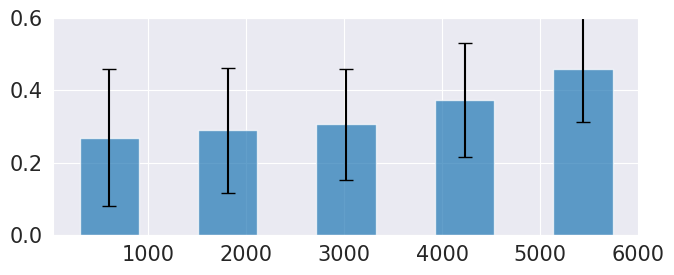

In [19]:
moe_vali_100 = np.load('./data/recsys_data/ml-1m/mainstream_scores/moe_folder/MOE_scores_20230118-1905_vali_acc/100_moe_test_scores.npy', allow_pickle=True)
moe_vali_100 = moe_vali_100.item()['NDCG@20']
moe_vali_100 = np.array(moe_vali_100)
distribution_plot(np.arange(dataset.num_users), moe_vali_100[user_sort_idx], bins=5)

[0.2716596538778125, 0.2887255703532261, 0.3067309719248102, 0.3738998582933728, 0.45870796607013764]


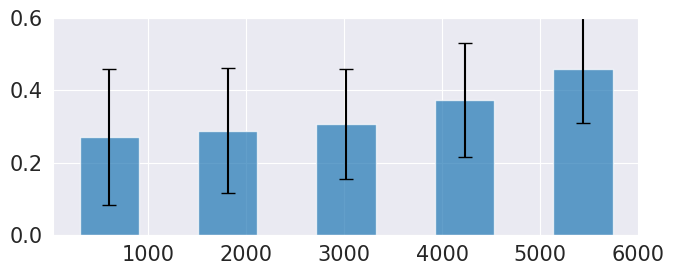

In [20]:
moe_loss = np.load('./data/recsys_data/ml-1m/mainstream_scores/moe_folder/MOE_scores_20230118-1837/100_moe_test_scores.npy', allow_pickle=True)
moe_loss = moe_loss.item()['NDCG@20']
moe_loss = np.array(moe_loss)
distribution_plot(np.arange(dataset.num_users), moe_loss[user_sort_idx], bins=5)

[0.2686722601241561, 0.2875821540779987, 0.3069335960564074, 0.37436899623201186, 0.4604455540902861]


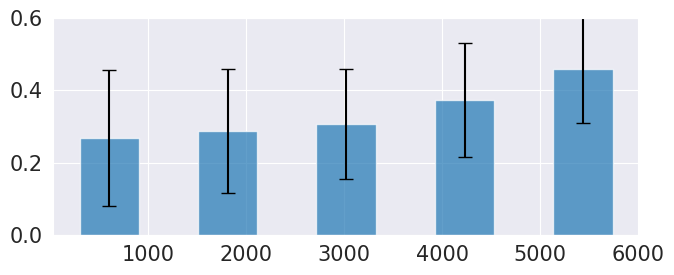

In [21]:
# MOE_scores_20230124-2142
moe_aw = np.load('./data/recsys_data/ml-1m/mainstream_scores/moe_folder_f/MOE_scores_20230130-1610/100_moe_test_scores.npy', allow_pickle=True)
moe_aw = moe_aw.item()['NDCG@20']
moe_aw = np.array(moe_aw)
distribution_plot(np.arange(dataset.num_users), moe_aw[user_sort_idx], bins=5)

In [22]:
# 20221118-1602_gate_output_softmax_3m3.npy
# 20221120-1906_gate_output_softmax_3m3_gate_para_fixed_1layer.npy
# 20221120-1922_gate_output_softmax_3m3_gate_para_fixed_3layers.npy
# 20221120-1947_gate_output_softmax_3m3_average_experts.npy

# gate_10 = np.load('./data/recsys_data/ml-1m/mainstream_scores/gate_output_ms/100_20221211-0514_tau_1_1/gate_output_dis.npy')
# plt.scatter(np.arange(len(gate_10)), gate_10[:, 0])
# # plt.scatter(user_sort_idx, gate_10[:, 0])

In [23]:
# plt.scatter(np.arange(len(gate_10)), gate_10[:, 1])

In [24]:
# plt.scatter(np.arange(len(gate_10)), gate_10[:, 2])

In [25]:
# plt.scatter(np.arange(len(gate_10)), gate_10[:, 3])

In [26]:
# plt.scatter(np.arange(len(gate_10)), gate_10[:, 4])

In [27]:
# gate_10.std(0)

In [28]:
# gate_10.mean(0)

In [29]:
# gate = np.load('./data/recsys_data/ml-1m/mainstream_scores/100_gate_initialize_enlft_new_preprocess.npy')

In [30]:
# n_g = gate / np.sum(gate, axis=1, keepdims=True)
# n_g

In [31]:
# sm = np.exp(gate) / np.sum(np.exp(gate), axis=1, keepdims=True)
# sm
# # gate.shape

In [32]:
# expert = np.load('./data/recsys_data/ml-1m/mainstream_scores/avg_experts_ms/3_20221224-0149/0_avg_experts_dis.npy')
# plt.scatter(np.arange(len(expert)), expert)

In [33]:
# expert = np.load('./data/recsys_data/ml-1m/mainstream_scores/avg_experts_ms/3_20221224-0149/1_avg_experts_dis.npy')
# plt.scatter(np.arange(len(expert)), expert)

In [34]:
# expert = np.load('./data/recsys_data/ml-1m/mainstream_scores/avg_experts_ms/3_20221224-0149/2_avg_experts_dis.npy')
# plt.scatter(np.arange(len(expert)), expert)